In [1]:
using Revise
using DrWatson

In [2]:
@quickactivate :ReactiveMPPaperExperiments

┌ Info: Precompiling ReactiveMPPaperExperiments [adcd1038-27e6-4580-819b-caa5dba07e45]
└ @ Base loading.jl:1342
┌ Info: Precompiling NamedArrays [86f7a689-2022-50b4-a561-43c23ac3c673]
└ @ Base loading.jl:1342


In [ ]:
using CairoMakie # Plots related stuff
using Turing, MCMCChains, Distributions, LinearAlgebra, Random # Bayesian Inference packages
using BenchmarkTools, DataFrames, Query # Analysis tools

import ReactiveMP # For collect_results

┌ Info: Precompiling CairoMakie [13f3f980-e62b-5c42-98c6-ff1f3baf88f0]
└ @ Base loading.jl:1342
┌ Warning: The call to compilecache failed to create a usable precompiled cache file for MathTeXEngine [0a4f8689-d25c-4efe-a92b-7142dfc1aa53]
│   exception = Required dependency GeometryBasics [5c1252a2-5f33-56bf-86c9-59e7332b4326] failed to load from a cache file.
└ @ Base loading.jl:1055
┌ Warning: Module GeometryBasics with build ID 174177778231432 is missing from the cache.
│ This may mean GeometryBasics [5c1252a2-5f33-56bf-86c9-59e7332b4326] does not support precompilation but is imported by a module that does.
└ @ Base loading.jl:1030
┌ Warning: Module GeometryBasics with build ID 174177778231432 is missing from the cache.
│ This may mean GeometryBasics [5c1252a2-5f33-56bf-86c9-59e7332b4326] does not support precompilation but is imported by a module that does.
└ @ Base loading.jl:1030


This demo aligns with similar demo ReactiveMP.jl and skips most of the explanations. For a rigorous description and model explanation check corresponding ReactiveMP.jl demo

### Data

In [72]:
params = let
    # Seed for reproducability
    seed = 42
    
    # Number of IID samples
    n = 50
    
    # Number of mixture components
    nmixtures = 6
    
    # Mixture component mean distance from zero
    cdistance = 10
    
    # Angle change rate
    angle = 1.5π / nmixtures
    
    @strdict seed n nmixtures cdistance angle
end;

In [82]:
y, mixtures = generate_data(GMMModel(), params);

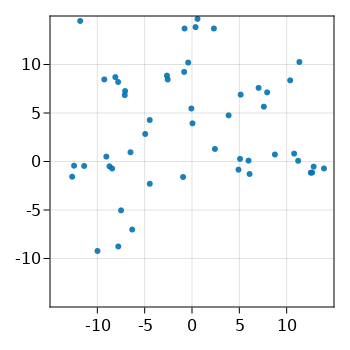

In [74]:
let
    @unpack seed, nmixtures, cdistance, angle, n = params
    
    sdim    = (n) -> (a) -> map(d -> d[n], a)
    limits  = (-1.5cdistance, 1.5cdistance)

    fig = Figure(resolution = (350, 350))
    ax = Makie.Axis(fig[1, 1])

    ax.xticks = [ -10, -5, 0, 5, 10 ]
    ax.yticks = [ -10, -5, 0, 5, 10 ]

    xlims!(ax, limits)
    ylims!(ax, limits)

    palette = fig.scene.palette.color[]

    scatter!(ax, 
        y |> sdim(1), y |> sdim(2), 
        markersize = 6, color = (palette[1], 0.9), 
        label = "Observations"
    )

    @saveplot fig "gmm_data"
end

### Model specification

In [96]:
@model function GaussianMixtureModel(y, nmixtures)
    n = length(y)
    k = length(first(y))
    
    @assert k === 2

    z = Vector{Float64}(undef, n)
    m = Vector{Vector}(undef, nmixtures)
    w = Vector{Matrix}(undef, nmixtures)
    
    for i in 1:nmixtures
        m[i] ~ MvNormal(zeros(2), [ 1e3 0.0; 0.0 1e3 ])
        w[i] ~ InverseWishart(2, [ 1e3 0.0; 0.0 1e3 ])
    end
    
    s ~ Dirichlet(nmixtures, 1.0)

    # Draw assignments for each datum and generate it from a multivariate normal.
    z = Vector{Int}(undef, n)
    
    for i in 1:n
        z[i] ~ Categorical(s)
        y[i] ~ MvNormal(m[z[i]], w[z[i]])
    end
end;

In [97]:
gmm_model = GaussianMixtureModel(y, 6);

In [98]:
gmm_sampler = Gibbs(PG(60, :z), HMC(0.05, 50, :m, :w))

Gibbs{(:z, :m, :w), Tuple{PG{(:z,), AdvancedPS.ResampleWithESSThreshold{typeof(AdvancedPS.resample_systematic), Float64}}, HMC{Turing.Core.ForwardDiffAD{40}, (:m, :w), AdvancedHMC.UnitEuclideanMetric}}}((PG{(:z,), AdvancedPS.ResampleWithESSThreshold{typeof(AdvancedPS.resample_systematic), Float64}}(60, AdvancedPS.ResampleWithESSThreshold{typeof(AdvancedPS.resample_systematic), Float64}(AdvancedPS.resample_systematic, 0.5)), HMC{Turing.Core.ForwardDiffAD{40}, (:m, :w), AdvancedHMC.UnitEuclideanMetric}(0.05, 50)))

In [99]:
tchain = sample(gmm_model, gmm_sampler, 250);

Sampling: 100%|█████████████████████████████████████████| Time: 0:03:53


In [100]:
Turing.summarize(tchain, Turing.mean, Turing.std)


  parameters          mean           std 
      Symbol       Float64       Float64 

     m[1][1]        4.8011       22.4683
     m[1][2]        4.3667       25.9704
     m[2][1]       -3.9988        9.5449
     m[2][2]       -0.7577        9.9739
     m[3][1]       -0.3567        2.6981
     m[3][2]        5.5267        6.2340
     m[4][1]       -0.7074        9.0525
     m[4][2]       -7.6459        6.6161
     m[5][1]      -13.9936       14.5176
     m[5][2]      -22.4332        6.9243
     m[6][1]        5.5028       10.1421
     m[6][2]       -2.9262        7.9661
   w[1][1,1]   221290.0041   697315.1449
   w[1][2,1]   -90753.5368   103941.5721
   w[1][1,2]   -90753.5368   103941.5721
   w[1][2,2]    96381.6124    26485.6546
   w[2][1,1]      448.6847     1859.6037
   w[2][2,1]      273.3681      960.9513
   w[2][1,2]      273.3681      960.9513
   w[2][2,2]      413.7643      835.9016
   w[3][1,1]      102.0072       40.8429
   w[3][2,1]      -16.9763       73.9795
   w[3][1,2]

In [101]:
mixtures[1] |> mean

2-element Vector{Float64}:
 10.0
  0.0